In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [52]:
"""def myrate(t):
    if t>=17 and t<28:
        return 0.36
    elif t>=28 and t < 85:
        return 0.26
    else:
        return 1"""

'def myrate(t):\n    if t>=17 and t<28:\n        return 0.36\n    elif t>=28 and t < 85:\n        return 0.26\n    else:\n        return 1'

In [53]:
def mymodel(t, z, beta, mu, gamma, fD, delta_c, k, nu, r):
    S = z[0]
    E = z[1]
    I = z[2]
    R = z[3]
    H = z[4]
    D = z[5]
    N = S+E+I+R+H
    dD = gamma_H*H
    dH = fD*gamma*I - gamma_H*H - nu*H
    dR = (1-fD)*gamma*I + nu*H
    dI = mu*E - gamma*I
    dS = -beta*S*I/N#(1+(dD/delta_c)**k)
    dE = beta*S*I/N - mu*E #(1+(dD/delta_c)**k)
    return [dS, dE, dI, dR, dH, dD]

In [54]:
beta = 2.25
mu = 0.2
gamma = 0.145
gamma_H = 0.022
fD = 0.08
k = 1
nu = 0.048
delta_c = 5/60*1e-6
r = 0.3

In [55]:
E0 = 1695
I0 = 308.8
H0 = 127.4
R0 = 311.1
S0 = 60.352*1e6
D0 = 0
z0 = [S0, E0, I0, R0, H0, D0]

In [56]:
sol = solve_ivp(mymodel, [0,85], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r))


In [57]:
t = np.arange(85)
x = sol.sol(t)
S = x[0].T
E = x[1].T
I = x[2].T
R = x[3].T
H = x[4].T
D = x[5].T

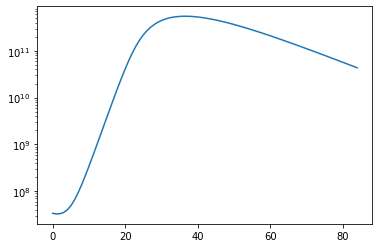

In [58]:
dD = gamma_H*H
N = S+E+I+R+H
FOI = I*beta*r/N
paura = (1+(dD/delta_c)**1)
plt.plot(t,paura)
plt.yscale('log')

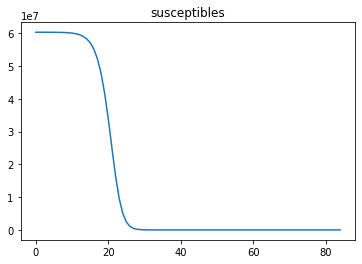

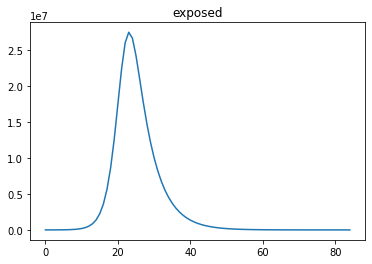

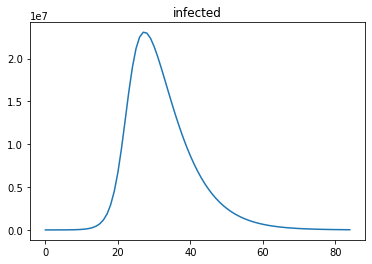

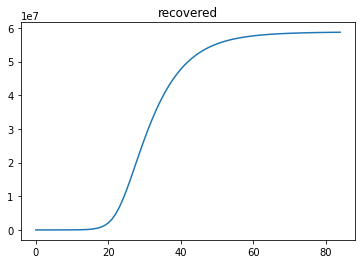

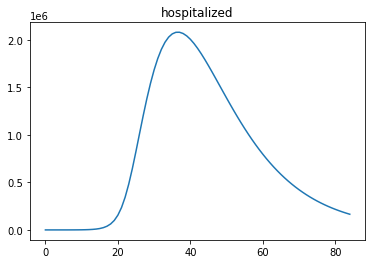

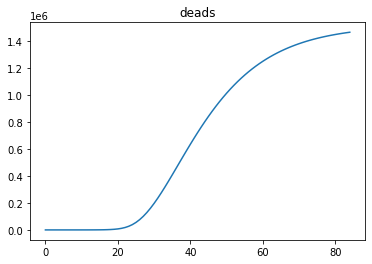

In [59]:
names = ['susceptibles', 'exposed', 'infected', 'recovered', 'hospitalized', 'deads']
for i,col in enumerate(x):
    plt.figure(i)
    plt.plot(t, col.T)
    plt.title(names[i])